# PSO example
This notebook is a short example showing how to solve a global optimization problem with the NAG PSO solver.

We will minimize Himmelblau's function:
$$
\min_{x,y} (x^2 + y - 11)^2 + (x + y^2 - 7)^2\\
-5 \leq x, y \leq 5
$$

We can start by ploting the function on the feasible domain using matplotlib:

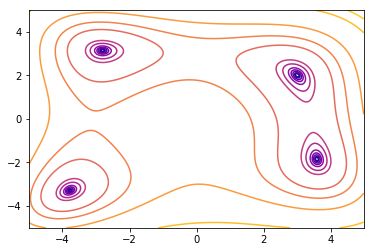

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
X, Y = np.meshgrid(np.arange(-5.,5.,0.02), np.arange(-5.,5.,0.02))
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2
lev = [0.1, 0.2, 0.5, 1., 2., 5., 10., 50., 100., 200., 500., 700., 1000., 2000.]
ax.contour(X, Y, Z, levels=lev, norm=LogNorm(), cmap=cm.plasma)
plt.show()

We can see this function has four local minima in the feasible doamin, all with a function value of 0.0.

We can now define the actual model that will be solved by the solver:

In [2]:
# bounds on the variables
bl = [-5., -5.]
bu = [5., 5.]
# number of particles in the swarm
npar = 20

Define the callback objective function. We add a user data structure to record the points evaluated by the solver, they will be used for the final plot.

In [3]:
class usr_data:
    def __init__(self):
        self.npts = 0
        self.pts = []
        
def objfun(mode, x, objf, vecout, nstate, data=None):
    # Himmelblau's function
    objf = (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2
    if mode > 0:
        vecout[0] = 4*x[0]*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
        vecout[1] = 2*(x[0]**2 + x[1] - 11) + 4*x[1]*(x[0] + x[1]**2 - 7)
    
    if data is not None:
        # record the objective evaluations every two calls to objfun
        data.npts += 1
        if (np.mod(data.npts, 5) == 2):
            data.pts.append((x[0], x[1]))
    return objf, vecout      

The model is ready, we can call the solver:

In [4]:
from naginterfaces.base import utils
from naginterfaces.library import glopt
import warnings 

# initialize the io manager 
iom = utils.FileObjManager(locus_in_output=False)
warnings.simplefilter("ignore", utils.NagAlgorithmicWarning)

# Initialize the communication structure for the solver and set some optional parameter
comm = {}
glopt.optset('Initialize = E05SAF', comm, io_manager=iom)
glopt.optset('Local Minimizer = e04kzf', comm, io_manager=iom)
# Change 'Advance Global' to control the level of diving towards local solution
glopt.optset('Advance Global = 0.2', comm, io_manager=iom) 

# Call the solver
data = usr_data()
sln = glopt.bnd_pso(bl, bu, objfun, comm, npar, monmod=None, data=data, io_manager=iom)

print('The solver converged with inform =', sln.inform)
print()
    
    
print('The best computed point is:    ', 'x  = ', sln.xb[0])
print('                               ', 'y  = ', sln.xb[1])
print('Final objective:               ', 'f  = ', sln.fb)
print('Number of function evaluations:', 'nf = ', sln.itt[4])

The solver converged with inform = 4

The best computed point is:     x  =  3.5844283403459682
                                y  =  -1.84812652713257
Final objective:                f  =  4.091216618606313e-19
Number of function evaluations: nf =  2251


To visualize the points evaluated, let's plot again the level set of the function and add a scatter plot of the list of points requested by the solver:

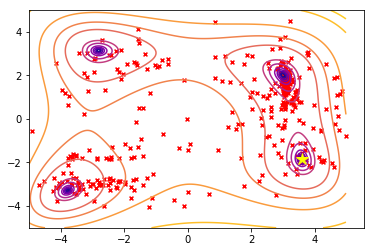

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, Z, levels=lev, norm=LogNorm(), cmap=cm.plasma)
ax.scatter(*zip(*data.pts), s=15, marker='x', c='red')
ax.plot(sln.xb[0], sln.xb[1], markersize=12, marker='*', c='yellow')
plt.show()